In [59]:
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_datareader
import datetime
import pandas_datareader.data as web
from scipy.stats import norm
import yfinance as yf
import cufflinks as cf
cf.go_offline()

In [60]:


tickers = ["ACE.NS","FILATEX.NS","GLOBUSSPR.NS","GNA.NS","IMFA.NS","SANDUMA.BO","PETRONET.NS",
           "HEIDELBERG.BO","GMBREW.NS"]

In [61]:
data = pd.DataFrame()

for t in tickers:
    data[t] = web.DataReader(t, data_source='yahoo', start='2016-1-1')['Adj Close']
     

        
data.to_csv("QUALITYNEESTOCKAUGUST120222.csv")

In [62]:
returns = np.log(data / data.shift(1))
vols = returns.std() * 252 ** 0.5 *100
vols

ACE.NS           53.167472
FILATEX.NS       56.281243
GLOBUSSPR.NS     55.110840
GNA.NS           47.484380
IMFA.NS          51.928965
SANDUMA.BO       69.317922
PETRONET.NS      29.216820
HEIDELBERG.BO    34.582633
GMBREW.NS        48.232482
dtype: float64

In [63]:
annual_returns = returns.mean() * 252 * 100
annual_returns

ACE.NS           26.373097
FILATEX.NS       38.556929
GLOBUSSPR.NS     37.241112
GNA.NS           18.630849
IMFA.NS          22.247584
SANDUMA.BO        9.802032
PETRONET.NS      11.516545
HEIDELBERG.BO    16.052289
GMBREW.NS         0.700911
dtype: float64

In [64]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import pandas_datareader.data as web
import datetime
import math

class ValueAtRiskMonteCarlo:
    
    def __init__(self, S, mu, sigma, c, n, iterations):
        self.S = S
        self.mu = mu
        self.sigma = sigma
        self.c = c
        self.n = n
        self.iterations = iterations 

    def simulation(self):
        stock_data = np.zeros([self.iterations, 1])	
        rand = np.random.normal(0, 1, [1, self.iterations])

        #equation for the S(t) stock price
        stock_price = self.S*np.exp(self.n*(self.mu - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.n)*rand)
        #we have to sort the stock prices to determine the percentile
        stock_price = np.sort(stock_price)

        #it depends on the confidence level: 95% -> 5 and 99% -> 1
        percentile = np.percentile(stock_price,(1-self.c)*100)

        return self.S-percentile

In [65]:

df = pd.DataFrame(columns = ['Ticker', 'Cov_mar','Market_var','Beta','Volatility%','Return%','CV','Sharp Ratio','CAGR','MAXDD%','Value at Risk']) 
data = pd.DataFrame()
data['^BSESN'] = web.DataReader('^BSESN', data_source='yahoo', start='2015-1-1')['Adj Close'] 

for t in tickers:
    try:
        data[t] = web.DataReader(t, data_source='yahoo', start='2015-1-1')['Adj Close']  
    except:
        continue
    sec_returns = np.log( data / data.shift(1) )
    cov = sec_returns.cov()*252
    cov_with_market = cov[t][0]
 
      
    dr = data[t].pct_change()
    dcum = (1 + dr).cumprod()
    n = len(data)/252
    CAGR = ((dcum[-1])**(1/n) - 1)*100
      
 
    
    droll = dcum.cummax()
    ddw = droll - dcum
    ddmax = ddw/droll
    max_dd = (ddmax.max())*100
   
 

    market_var = sec_returns['^BSESN'].var() * 252

    returns = np.log(data[t] / data[t].shift(1))
    MSFT_beta = cov_with_market / market_var
    MSFT_er = returns.mean()*252
    Sharp = (MSFT_er - 0.05) / (sec_returns[t].std() * 252 ** 0.5)
   

    #returns = np.log(data[t] / data[t].shift(1))
    vols = returns.std() * 252 ** 0.5 *100
    annual_returns = returns.mean() * 252 * 100
    CV = (vols/annual_returns)*100
    S = 100000    #this is the investment (stocks or whatever)
    c=0.95   #condifence level: this time it is 99%
    n = 730   #1 day 
    iterations = 100000 #number of paths in the Monte-Carlo simulation
    mu = np.mean(returns)
    sigma = np.mean(returns.std())

    model = ValueAtRiskMonteCarlo(S,mu,sigma,c,n,iterations)
    val = model.simulation()

 
    
 
    df = df.append(pd.Series([t,cov_with_market,market_var,MSFT_beta,vols,annual_returns,CV,Sharp,CAGR,max_dd,val], index=df.columns ), ignore_index=True)
                                    
                        
  

/var/folders/jx/qw4vpgyd2gxg8zhm3nm041j40000gp/T/ipykernel_8607/3993741060.py:54: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/jx/qw4vpgyd2gxg8zhm3nm041j40000gp/T/ipykernel_8607/3993741060.py:54: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/jx/qw4vpgyd2gxg8zhm3nm041j40000gp/T/ipykernel_8607/3993741060.py:54: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/jx/qw4vpgyd2gxg8zhm3nm041j40000gp/T/ipykernel_8607/3993741060.py:54: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/jx/qw4vpgyd2gxg8zhm3nm041j40000gp/T/ipykernel_8607/3993741060.py:54: FutureWarning:

The frame.append method is depreca

In [66]:
df1 = df[(df['CAGR']>10 ) & (df['Return%']>10)]
df2 = df1.sort_values(by='Return%', ascending=False)
df2

,Ticker,Cov_mar,Market_var,Beta,Volatility%,Return%,CV,Sharp Ratio,CAGR,MAXDD%,Value at Risk
1,FILATEX.NS,0.031354,0.032349,0.969242,57.526325,39.310995,146.336476,0.59644,48.127201,73.407644,61044.564944
2,GLOBUSSPR.NS,0.033351,0.032349,1.030987,55.439816,34.637863,160.055532,0.534595,41.36778,68.944695,63235.009901
8,GMBREW.NS,0.026593,0.032349,0.822071,51.578128,31.20721,165.276316,0.508107,36.602679,74.124164,60725.743247
0,ACE.NS,0.040382,0.032349,1.248336,52.973061,24.955547,212.269685,0.376711,28.328467,83.294522,68999.205017
3,GNA.NS,0.028239,0.032349,0.872968,47.59086,18.694741,254.568175,0.28776,15.575371,75.305729,67478.195403
4,IMFA.NS,0.034791,0.032349,1.075501,53.347739,14.144571,377.160518,0.171414,15.185144,85.776756,77535.463625
7,HEIDELBERG.BO,0.028714,0.032349,0.887633,34.877338,13.155457,265.116883,0.233833,14.052047,41.197185,53661.028417
6,PETRONET.NS,0.020298,0.032349,0.627488,29.025475,12.940517,224.299192,0.273571,13.807296,38.29265,42553.011464


In [67]:
df2.to_csv("QUALITYGROWTHSMALLAUG2022.csv")

Text(0, 0.5, 'Expected Return')

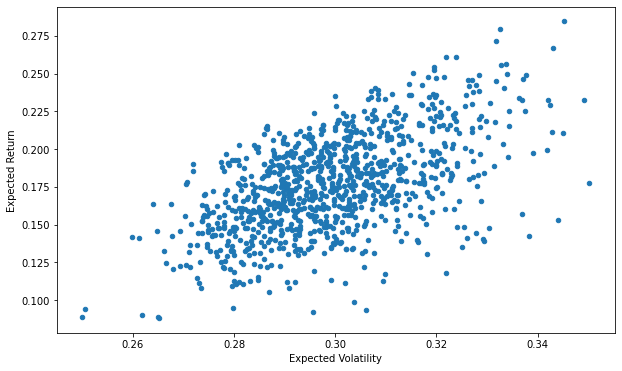

In [68]:
pf_data = pd.DataFrame()
for t in df1["Ticker"]:
    pf_data[t] = web.DataReader(t, data_source = 'yahoo', start = '2019-1-1')['Adj Close']

log_returns = np.log(pf_data / pf_data.shift(1))
num_assets = len(df1["Ticker"])
num_assets
weights = np.random.random(num_assets)
weights /= np.sum(weights)
np.sum(weights * log_returns.mean()) * 252
np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * 252, weights)))
pfolio_returns = []
pfolio_volatilities = []
wts = []
for x in range (1000):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    pfolio_returns.append(np.sum(weights * log_returns.mean()) * 252)
    pfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * 252, weights))))
    wts.append(weights)
pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)
wts= np.array(wts)
#pfolio_returns, pfolio_volatilities
portfolios = pd.DataFrame({'Return': pfolio_returns, 'Volatility': pfolio_volatilities})
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10, 6));
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

In [69]:
df = pd.DataFrame(data=wts)
df.columns = df1["Ticker"]
df_col_merged = pd.concat([portfolios, df], axis=1)
dft = df_col_merged.loc[df_col_merged['Return'].argmax()]
dft*100

Return           28.449865
Volatility       34.522378
ACE.NS           17.394676
FILATEX.NS        2.017735
GLOBUSSPR.NS     32.932726
GNA.NS            6.615825
IMFA.NS          25.378776
PETRONET.NS       7.217984
HEIDELBERG.BO     4.174965
GMBREW.NS         4.267313
Name: 501, dtype: float64

In [70]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import pandas_datareader.data as web
import datetime
import math

class ValueAtRiskMonteCarlo:
    
    def __init__(self, S, mu, sigma, c, n, iterations):
        self.S = S
        self.mu = mu
        self.sigma = sigma
        self.c = c
        self.n = n
        self.iterations = iterations 

    def simulation(self):
        stock_data = np.zeros([self.iterations, 1])	
        rand = np.random.normal(0, 1, [1, self.iterations])

        #equation for the S(t) stock price
        stock_price = self.S*np.exp(self.n*(self.mu - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.n)*rand)
        #we have to sort the stock prices to determine the percentile
        stock_price = np.sort(stock_price)

        #it depends on the confidence level: 95% -> 5 and 99% -> 1
        percentile = np.percentile(stock_price,(1-self.c)*100)

        return self.S-percentile

if __name__ == "__main__":
    S = 100000    #this is the investment (stocks or whatever)
    c=0.95   #condifence level: this time it is 99%
    n = 730   #1 day 
    iterations = 100000 #number of paths in the Monte-Carlo simulation

    #historical data to approximate mean and standard deviation
    d = {}

    #download stock related data from Yahoo Finance
    for t in df1["Ticker"]:
        citi = web.DataReader(t,data_source='yahoo',start='2017-1-1')
           #we can use pct_change() to calculate daily returns
        citi['returns'] = citi['Adj Close'].pct_change()

    #we can assume daily returns to be normally sidtributed: mean and variance (standard deviation)
    #can describe the process
        mu = np.mean(citi['returns'])
        sigma = np.std(citi['returns'])

        model = ValueAtRiskMonteCarlo(S,mu,sigma,c,n,iterations)
        val = model.simulation()
        d[t] = val
        print("VALUE AT RSIK for {} is".format(t))
        print('Value at risk with Monte-Carlo simulation in INR: %0.2f' % val)
    print("The minimum value at risk for the portofolios are:")
    print(min(d.values()))

VALUE AT RSIK for ACE.NS is
Value at risk with Monte-Carlo simulation in INR: 46647.29
VALUE AT RSIK for FILATEX.NS is
Value at risk with Monte-Carlo simulation in INR: 38609.67
VALUE AT RSIK for GLOBUSSPR.NS is
Value at risk with Monte-Carlo simulation in INR: 27363.93
VALUE AT RSIK for GNA.NS is
Value at risk with Monte-Carlo simulation in INR: 46524.19
VALUE AT RSIK for IMFA.NS is
Value at risk with Monte-Carlo simulation in INR: 75835.57
VALUE AT RSIK for PETRONET.NS is
Value at risk with Monte-Carlo simulation in INR: 45239.72
VALUE AT RSIK for HEIDELBERG.BO is
Value at risk with Monte-Carlo simulation in INR: 44586.72
VALUE AT RSIK for GMBREW.NS is
Value at risk with Monte-Carlo simulation in INR: 66028.86
The minimum value at risk for the portofolios are:
27363.92951027579


In [71]:
for key,value in d.items():
    print(" The Value at risk per 1L invested in stock {} is {:0.2f}".format(key,value))

 The Value at risk per 1L invested in stock ACE.NS is 46647.29
 The Value at risk per 1L invested in stock FILATEX.NS is 38609.67
 The Value at risk per 1L invested in stock GLOBUSSPR.NS is 27363.93
 The Value at risk per 1L invested in stock GNA.NS is 46524.19
 The Value at risk per 1L invested in stock IMFA.NS is 75835.57
 The Value at risk per 1L invested in stock PETRONET.NS is 45239.72
 The Value at risk per 1L invested in stock HEIDELBERG.BO is 44586.72
 The Value at risk per 1L invested in stock GMBREW.NS is 66028.86


In [72]:
df2.reset_index(inplace = True)

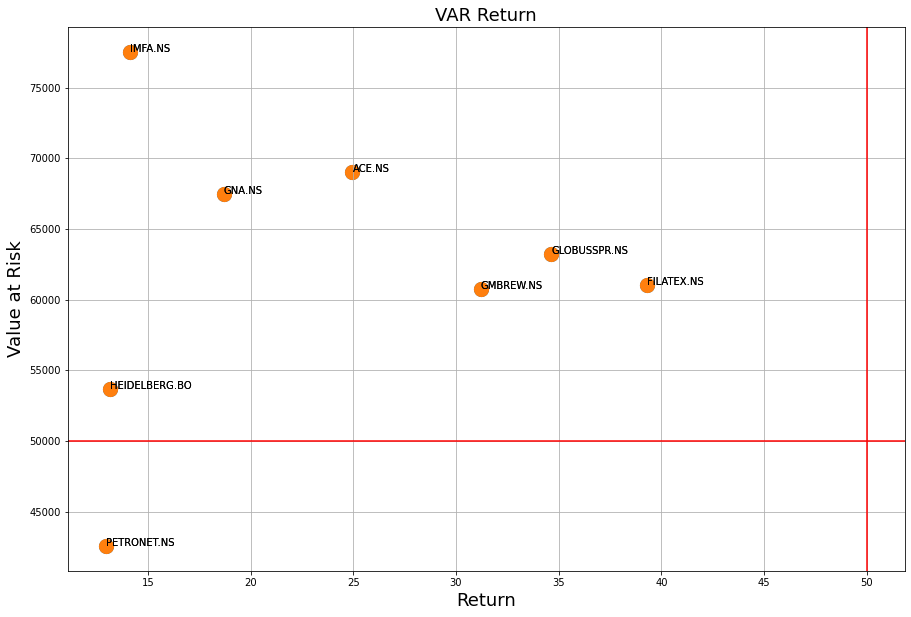

In [73]:
plt.figure(figsize=[15,10])
x= df2['Return%']
y = df2['Value at Risk']
annotations = df2["Ticker"]
plt.grid(True)
plt.title('VAR Return', fontsize=18, color='black')
plt.xlabel("Return",fontsize=18, color='black')
plt.ylabel("Value at Risk", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50000, color='r', linestyle='-')
plt.show()

plt.show()

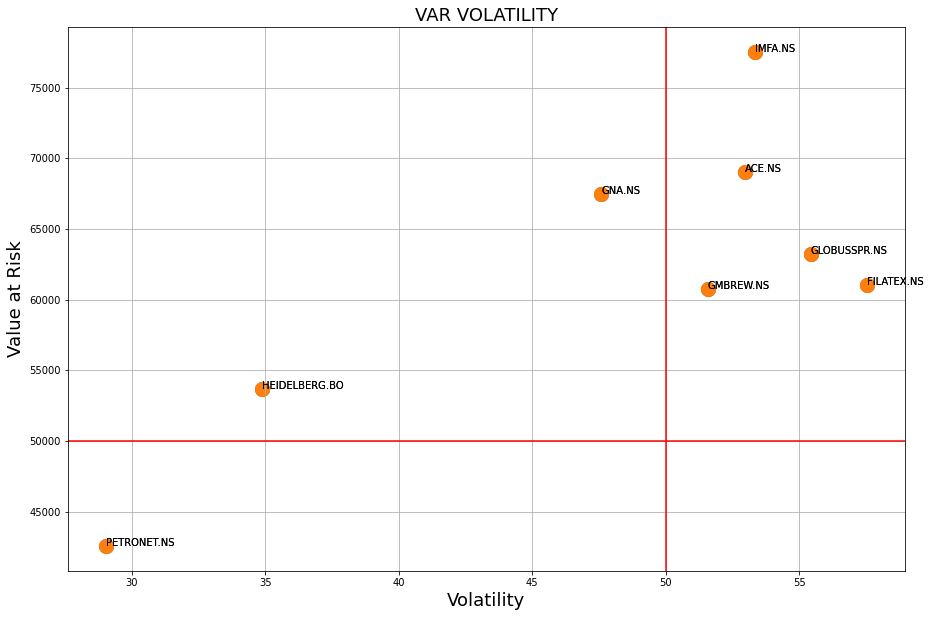

In [74]:
plt.figure(figsize=[15,10])
x= df2['Volatility%']
y = df2['Value at Risk']
annotations = df2["Ticker"]
plt.grid(True)
plt.title('VAR VOLATILITY', fontsize=18, color='black')
plt.xlabel("Volatility",fontsize=18, color='black')
plt.ylabel("Value at Risk", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50000, color='r', linestyle='-')
plt.show()

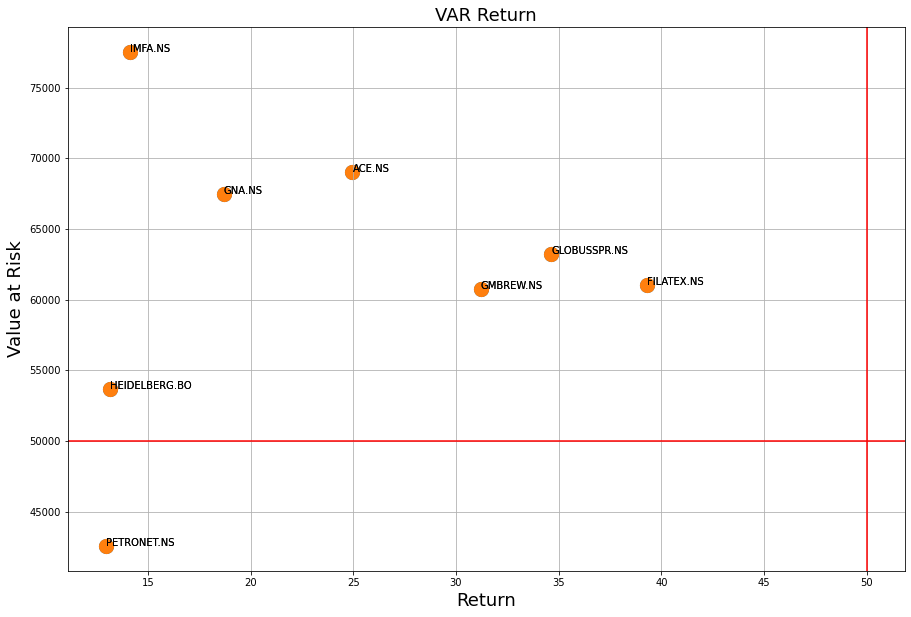

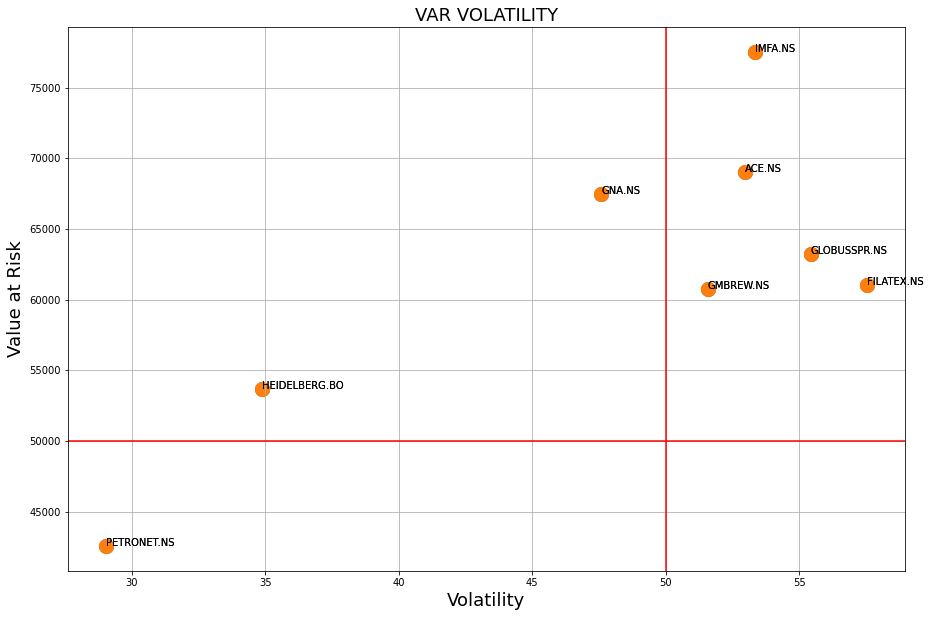

In [75]:
plt.figure(figsize=[15,10])
x= df2['Return%']
y = df2['Value at Risk']
annotations = df2["Ticker"]
plt.grid(True)
plt.title('VAR Return', fontsize=18, color='black')
plt.xlabel("Return",fontsize=18, color='black')
plt.ylabel("Value at Risk", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50000, color='r', linestyle='-')
plt.show()

plt.figure(figsize=[15,10])
x= df2['Volatility%']
y = df2['Value at Risk']
annotations = df2["Ticker"]
plt.grid(True)
plt.title('VAR VOLATILITY', fontsize=18, color='black')
plt.xlabel("Volatility",fontsize=18, color='black')
plt.ylabel("Value at Risk", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50000, color='r', linestyle='-')
plt.show()

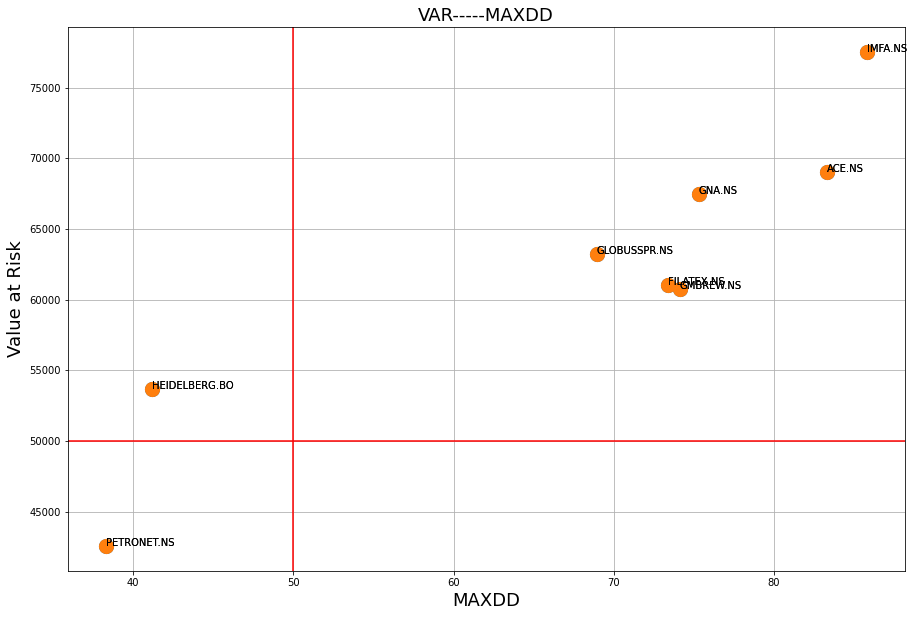

In [76]:

plt.figure(figsize=[15,10])
x= df2['MAXDD%']
y = df2['Value at Risk']
annotations = df2["Ticker"]
plt.grid(True)
plt.title('VAR-----MAXDD', fontsize=18, color='black')
plt.xlabel("MAXDD",fontsize=18, color='black')
plt.ylabel("Value at Risk", fontsize=18, color='black') 
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.scatter(x, y,s=200 )
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.axvline(x = 50, color = 'r', label = 'axvline - full height')
plt.axhline(y=50000, color='r', linestyle='-')
plt.show()

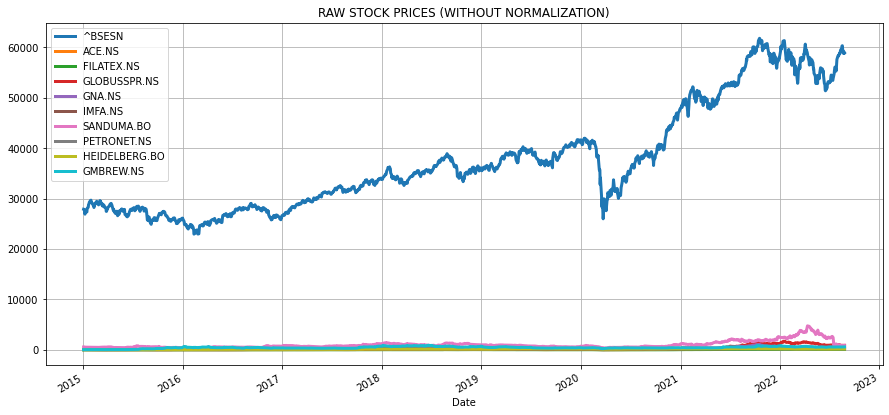

In [77]:
stocks_df = data
def show_plot(df, fig_title):
  df.plot(x = 'Date', figsize = (15,7), linewidth = 3, title = fig_title)
  plt.grid()
  plt.show()
stocks_df = stocks_df.reset_index()
show_plot(stocks_df, 'RAW STOCK PRICES (WITHOUT NORMALIZATION)')

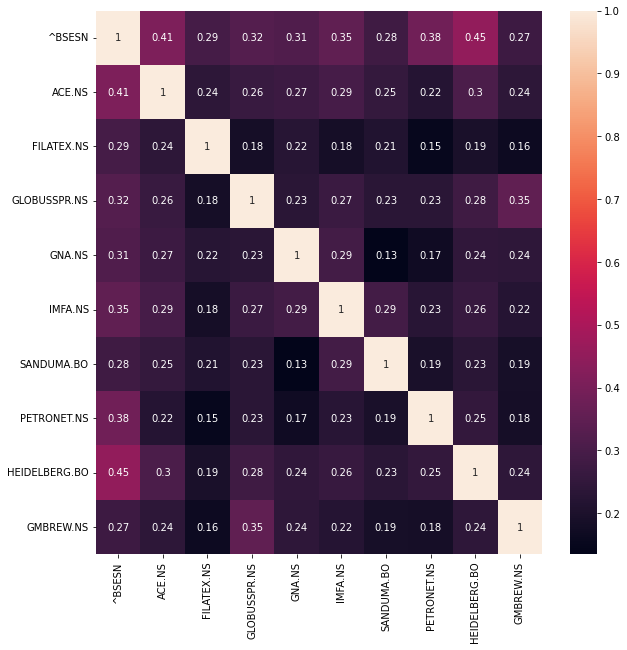

In [78]:
def daily_return(df):
  df_daily_return = df.copy()

  # Loop through each stock (while ignoring time columns with index 0)
  for i in df.columns[1:]:
    
    # Loop through each row belonging to the stock
    for j in range(1, len(df)):

      # Calculate the percentage of change from the previous day
      df_daily_return[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100
    
    # set the value of first row to zero since the previous value is not available
    df_daily_return[i][0] = 0
  
  return df_daily_return

# Get the daily returns 
stocks_daily_return = daily_return(stocks_df)
# Daily Return Correlation
cm = stocks_daily_return.drop(columns = ['Date']).corr()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from copy import copy
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
plt.figure(figsize=(10, 10))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax);

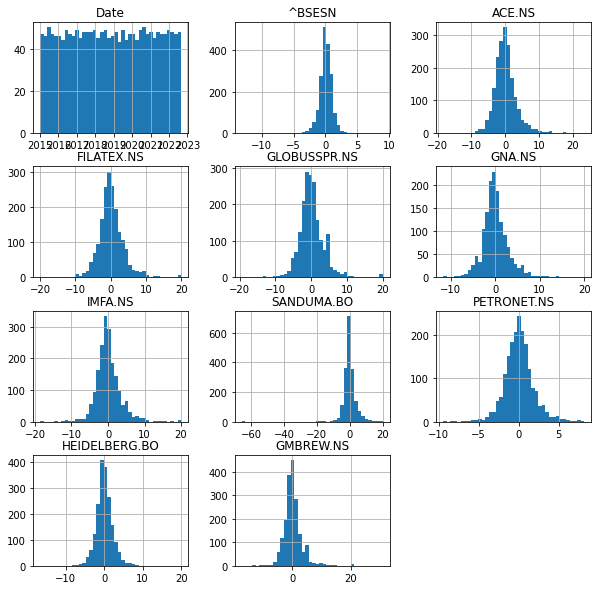

In [79]:
# Histogram of daily returns
# Stock returns are normally distributed with zero mean 
# Notice how Tesla Standard deviation is high indicating a more volatile stock
stocks_daily_return.hist(figsize=(10, 10), bins = 40);

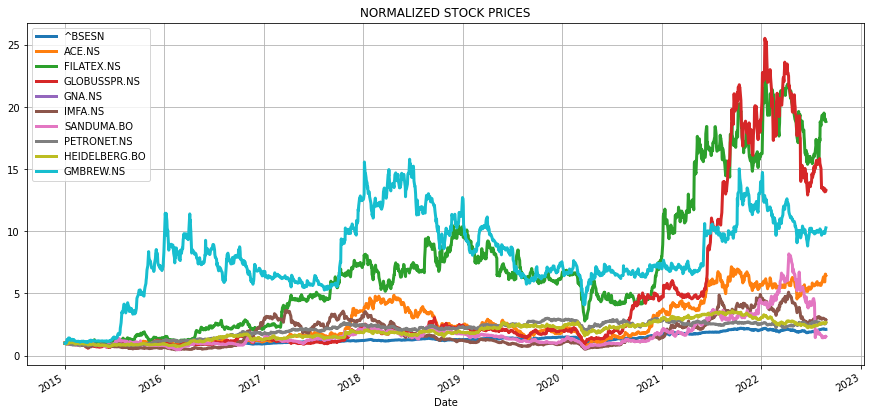

In [80]:
# Function to normalize the prices based on the initial price
# The function simply divides every stock by it's price at the start date (i.e.: Date = 2012-01-12)	
def normalize(df):
  x = df.copy()

  # Loop through each stock (while ignoring time columns with index 0)
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

# Plot normalized data
# Notice the massive gains in Tesla Stock compared to Amazon (second place)
show_plot(normalize(stocks_df), 'NORMALIZED STOCK PRICES')

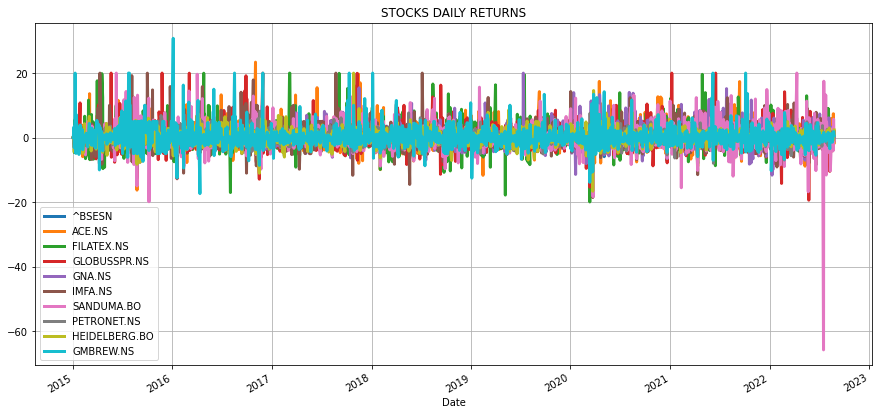

In [81]:
# Function to perform an interactive data plotting using plotly express
# Plotly.express module which is imported as px includes functions that can plot interactive plots easily and effectively. 
# Every Plotly Express function uses graph objects internally and returns a plotly.graph_objects.Figure instance. 

def interactive_plot(df, title):
  fig = px.line(title = title)
  
  # Loop through each stock (while ignoring time columns with index 0)
  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name = i) # add a new Scatter trace

  fig.show()
# Plot normalized interactive chart
interactive_plot(normalize(stocks_df), 'Normalized Prices')

# Plot the daily returns
# Notice huge drops in MGM around March 2020 (Pandemic effect)
show_plot(stocks_daily_return, 'STOCKS DAILY RETURNS')

In [82]:
df2.iplot(kind="scatter",
              x="CV", y='Value at Risk',
              mode='markers',
              xTitle="CV", yTitle="Value at Risk",
              title="========CV-------VAR=========================", categories="Ticker",theme="solar")

/Users/sjacob/Library/Python/3.8/lib/python/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.

/Users/sjacob/Library/Python/3.8/lib/python/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.



In [83]:

df1.iplot(kind="scatter",
              x="Return%", y='Volatility%',
              mode='markers',
              xTitle="Return", yTitle="Volatility",
              title="========Return-------Volatility=========================", categories="Ticker",theme="solar")

In [84]:

df2.iplot(kind="scatter",
              x="Return%", y='CV',
              mode='markers',
              xTitle="Return", yTitle="CV",
              title="========Return-------CV========================", categories="Ticker",theme="solar")

In [85]:

df2.iplot(kind="scatter",
              x="Return%", y='Value at Risk',
              mode='markers',
              xTitle="Return", yTitle="VAR",
              title="========Return------VAR========================", categories="Ticker",theme="solar")

In [86]:

df2.iplot(kind="scatter",
              x="Volatility%", y='Value at Risk',
              mode='markers',
              xTitle="Volatility", yTitle="VAR",
              title="========VOL------VAR========================", categories="Ticker",theme="solar")

In [87]:
df1['CV'] = df1['CV'].astype(float)
df1['Value at Risk'] = df1['Value at Risk'].astype(float)
df1['Return%'] = df1['Return%'].astype(float)
df1['Volatility%'] = df1['Volatility%'].astype(float)

print(df1.dtypes)

Ticker            object
Cov_mar           object
Market_var        object
Beta              object
Volatility%      float64
Return%          float64
CV               float64
Sharp Ratio       object
CAGR              object
MAXDD%            object
Value at Risk    float64
dtype: object


In [88]:
df1['CV'].astype(float)
df1['Value at Risk'].astype(float)
np.corrcoef(df1['CV'], df1['Value at Risk'])[0][1]

0.39475959160839563

In [89]:
df1.dtypes

Ticker            object
Cov_mar           object
Market_var        object
Beta              object
Volatility%      float64
Return%          float64
CV               float64
Sharp Ratio       object
CAGR              object
MAXDD%            object
Value at Risk    float64
dtype: object

In [90]:
def t_stat_corr(df, x, y):
    """Returns the t-statistic for the correlation between 2 variables"""
    corr_xy = np.corrcoef(df[x], df[y])[0][1]
    n = len(df)
    
    t_stat = (corr_xy * np.sqrt(n - 2)) / np.sqrt(1 - corr_xy ** 2)
    
    return t_stat

In [91]:
# H1
t_stat_corr(df=df1, y='Value at Risk', x='CV')

1.052433539691873

In [92]:
t_stat_corr(df=df1, y='Return%', x='CV')

-3.2836333586142037

In [93]:
t_stat_corr(df=df1, y='Volatility%', x='Return%')

2.6772507785118385

In [94]:
t_stat_corr(df=df1, y='Volatility%', x='CV')

-0.5636501891423659